<a href="https://colab.research.google.com/github/chahatpatel2003/CSCI-167/blob/main/NOTEBOOK_8_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

  Cloning https://github.com/greydanus/mnist1d to /tmp/pip-req-build-bhlcb1xh
  Running command git clone --filter=blob:none --quiet https://github.com/greydanus/mnist1d /tmp/pip-req-build-bhlcb1xh
  Resolved https://github.com/greydanus/mnist1d to commit 7878d96082abd200c546a07a4101fa90b30fdf7e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for mnist1d: filename=mnist1d-0.0.2.post16-py3-none-any.whl size=14665 sha256=258ee4af2eefc644a3a1e2ce239709b2f7a264bd2cade611f11c2e2b5938c34e
  Stored in directory: /tmp/pip-ephem-wheel-cache-3gcf41nu/wheels/18/40/b6/29381fee9b4c80fdbc304d52bb065a7286bbcca5ca2b8737c0
Successfully built mnist1d
Did or could not load data from ./mnist1d_data.pkl. Rebuilding dataset...
Examples in training set: 4000
Examples in test set: 1000
Length of each example: 40
Epoch     0, train loss 1.613497, train error 63.58,  test loss 1.665597, test error 67.90
Epoch 

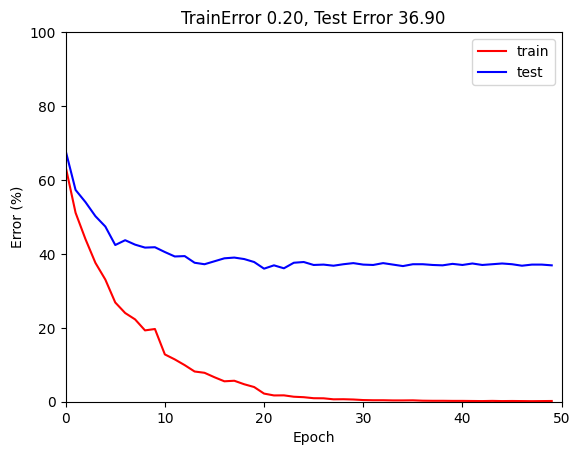

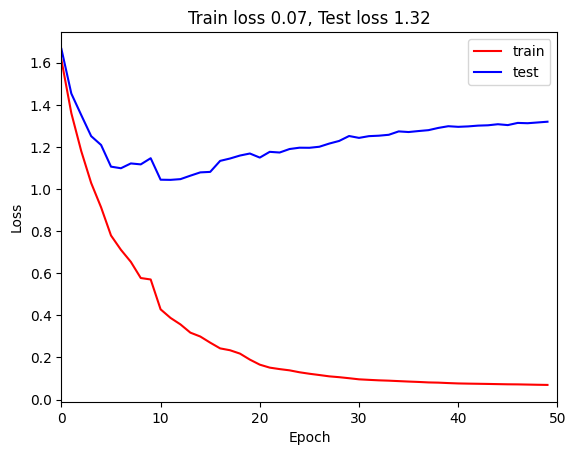

In [1]:
%pip install git+https://github.com/greydanus/mnist1d

import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR
import numpy as np
import matplotlib.pyplot as plt
import mnist1d

args = mnist1d.data.get_dataset_args()
data = mnist1d.data.get_dataset(args, path='./mnist1d_data.pkl', download=False, regenerate=False)

print("Examples in training set:", len(data['y']))
print("Examples in test set:", len(data['y_test']))
print("Length of each example:", data['x'].shape[-1])

D_i = 40
D_k = 100
D_o = 10

model = nn.Sequential(
    nn.Linear(D_i, D_k),
    nn.ReLU(),
    nn.Linear(D_k, D_k),
    nn.ReLU(),
    nn.Linear(D_k, D_o)
)

def weights_init(layer_in):
    if isinstance(layer_in, nn.Linear):
        nn.init.kaiming_normal_(layer_in.weight, nonlinearity='relu')
        if layer_in.bias is not None:
            nn.init.constant_(layer_in.bias, 0)

model.apply(weights_init)

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

x_train = torch.tensor(data['x'].astype('float32'))
y_train = torch.tensor(data['y'].transpose().astype('int64'))
x_test = torch.tensor(data['x_test'].astype('float32'))
y_test = torch.tensor(data['y_test'].astype('int64'))

data_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=100, shuffle=True, worker_init_fn=np.random.seed(1))

n_epoch = 50
losses_train = np.zeros(n_epoch)
errors_train = np.zeros(n_epoch)
losses_test = np.zeros(n_epoch)
errors_test = np.zeros(n_epoch)

for epoch in range(n_epoch):
    for i, batch in enumerate(data_loader):
        x_batch, y_batch = batch
        optimizer.zero_grad()
        pred = model(x_batch)
        loss = loss_function(pred, y_batch)
        loss.backward()
        optimizer.step()

    pred_train = model(x_train)
    pred_test = model(x_test)
    _, predicted_train_class = torch.max(pred_train.data, 1)
    _, predicted_test_class = torch.max(pred_test.data, 1)
    errors_train[epoch] = 100 - 100 * (predicted_train_class == y_train).float().sum() / len(y_train)
    errors_test[epoch] = 100 - 100 * (predicted_test_class == y_test).float().sum() / len(y_test)
    losses_train[epoch] = loss_function(pred_train, y_train).item()
    losses_test[epoch] = loss_function(pred_test, y_test).item()
    print(f'Epoch {epoch:5d}, train loss {losses_train[epoch]:.6f}, train error {errors_train[epoch]:3.2f},  test loss {losses_test[epoch]:.6f}, test error {errors_test[epoch]:3.2f}')
    scheduler.step()

fig, ax = plt.subplots()
ax.plot(errors_train, 'r-', label='train')
ax.plot(errors_test, 'b-', label='test')
ax.set_ylim(0, 100)
ax.set_xlim(0, n_epoch)
ax.set_xlabel('Epoch')
ax.set_ylabel('Error (%)')
ax.set_title('TrainError %3.2f, Test Error %3.2f' % (errors_train[-1], errors_test[-1]))
ax.legend()
plt.show()

fig, ax = plt.subplots()
ax.plot(losses_train, 'r-', label='train')
ax.plot(losses_test, 'b-', label='test')
ax.set_xlim(0, n_epoch)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Train loss %3.2f, Test loss %3.2f' % (losses_train[-1], losses_test[-1]))
ax.legend()
plt.show()
